In [ ]:
# this part is taken from M. J. Canty: https://developers.google.com/earth-engine/tutorials/community/imad-tutorial-pt3
# Enter your own export to assets path name here -----------
EXPORT_PATH = 'projects/ee-koziskoa-dp/assets/'

import ee
ee.Authenticate()
# Connect to my project number
ee.Initialize(project='716069062206')

# Import other packages used in the tutorial
%matplotlib inline
import geemap
import numpy as np
import random, time
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2

from pprint import pprint  # for pretty printing

In [ ]:
# this part is taken from M. J. Canty: https://developers.google.com/earth-engine/tutorials/community/imad-tutorial-pt3
# compared to the original code, the script is modified to use Landsat images.

def trunc(values, dec = 3):
    '''Truncate a 1-D array to dec decimal places.'''
    return np.trunc(values*10**dec)/(10**dec)

# Display an image in a one percent linear stretch.
def display_ls(image, map, name, centered = False):
    bns = image.bandNames().length().getInfo()
    if bns == 3:
        image = image.rename('B1', 'B2', 'B3')
        pb_99 = ['B1_p99', 'B2_p99', 'B3_p99']
        pb_1 = ['B1_p1', 'B2_p1', 'B3_p1']
        img = ee.Image.rgb(
            image.select('B1'), image.select('B2'), image.select('B3'))
    else:
        image = image.rename('B1')
        pb_99 = ['B1_p99']
        pb_1 = ['B1_p1']
        img = image.select('B1')
    percentiles = image.reduceRegion(
        ee.Reducer.percentile([1, 98]), maxPixels=1e11)
    mx = percentiles.values(pb_99)
    if centered:
        mn = ee.Array(mx).multiply(-1).toList()
    else:
        mn = percentiles.values(pb_1)
    map.addLayer(img, {'min': mn, 'max': mx}, name)

# create function for mask clouds
def mask_clouds(image):
    qa = image.select('QA_PIXEL')
    cloud_shadow_bit_mask = 1 << 3
    clouds_bit_mask = 1 << 5
    mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0) \
        .And(qa.bitwiseAnd(clouds_bit_mask).eq(0))
    return image.updateMask(mask)

def covarw(image, weights=None, scale=30, maxPixels=1e10):
    '''Return the centered image and its weighted covariance matrix.'''
    try:
        geometry = image.geometry()
        bandNames = image.bandNames()
        N = bandNames.length()
        if weights is None:
            weights = image.constant(1)
        weightsImage = image.multiply(ee.Image.constant(0)).add(weights)
        means = image.addBands(weightsImage) \
                    .reduceRegion(ee.Reducer.mean().repeat(N).splitWeights(),
                                scale=scale,
                                maxPixels=maxPixels) \
                    .toArray() \
                    .project([1])
        centered = image.toArray().subtract(means)
        B1 = centered.bandNames().get(0)
        b1 = weights.bandNames().get(0)
        nPixels = ee.Number(centered.reduceRegion(ee.Reducer.count(),
                                                scale=scale,
                                                maxPixels=maxPixels).get(B1))
        sumWeights = ee.Number(weights.reduceRegion(ee.Reducer.sum(),
                                                    geometry=geometry,
                                                    scale=scale,
                                                    maxPixels=maxPixels).get(b1))
        covw = centered.multiply(weights.sqrt()) \
                    .toArray() \
                    .reduceRegion(ee.Reducer.centeredCovariance(),
                                    geometry=geometry,
                                    scale=scale,
                                    maxPixels=maxPixels) \
                    .get('array')
        covw = ee.Array(covw).multiply(nPixels).divide(sumWeights)
        return (centered.arrayFlatten([bandNames]), covw)
    except Exception as e:
        print('Error: %s'%e)

def corr(cov):
    '''Transform covariance matrix to correlation matrix.'''
    # Diagonal matrix of inverse sigmas.
    sInv = cov.matrixDiagonal().sqrt().matrixToDiag().matrixInverse()
    # Transform.
    corr = sInv.matrixMultiply(cov).matrixMultiply(sInv).getInfo()
    # Truncate.
    return [list(map(trunc, corr[i])) for i in range(len(corr))]

def geneiv(C,B):
    '''Return the eigenvalues and eigenvectors of the generalized eigenproblem
       C*X = lambda*B*X'''
    try:
        C = ee.Array(C)
        B = ee.Array(B)
        #  Li = choldc(B)^-1
        Li = ee.Array(B.matrixCholeskyDecomposition().get('L')).matrixInverse()
        # Solve symmetric, ordinary eigenproblem Li*C*Li^T*x = lambda*x
        Xa = Li.matrixMultiply(C) \
            .matrixMultiply(Li.matrixTranspose()) \
            .eigen()
        # Eigenvalues as a row vector.
        lambdas = Xa.slice(1, 0, 1).matrixTranspose()
        # Eigenvectors as columns.
        X = Xa.slice(1, 1).matrixTranspose()
        # Generalized eigenvectors as columns, Li^T*X
        eigenvecs = Li.matrixTranspose().matrixMultiply(X)
        return (lambdas, eigenvecs)
    except Exception as e:
        print('Error: %s'%e)

# Collect a Sentinel-2 image pair.
def collect(aoi):
    '''Combination:
    LT05_191025_20000909 -> LC09_191025_20230917 L5 -> L9
    
    IM1 = REFERENCE IMAGE (L9)
    IM2 = TARET IMAGE (L5)
    '''
    
    try:
        bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'] # bands for Landsat 5 and 9
        reference = ee.Image( ee.ImageCollection('LANDSAT/LC09/C02/T1_L2') # master: landsat 9: LANDSAT/LC09/C02/T1_L2
                  .filter(ee.Filter.eq('system:index', 'LC09_191025_20230917')) # L9: LC09_191025_20230917
                  .first()
                  .clip(aoi)
                  )
        im1 = (ee.ImageCollection('LANDSAT/LC09/C02/T1_L2') # reference: landsat 9: LANDSAT/LC09/C02/T1_L2
                  .filter(ee.Filter.eq('system:index', 'LC09_191025_20230917')) # L9: LC09_191025_20230917
                  .first()
                  .filterBounds(aoi)
                  .filterDate('2023-08-01', '2023-09-24')
                  .filter(ee.Filter.lt('CLOUD_COVER', 10))
                  .map(mask_clouds)
                  .median()
                  .reproject(crs=reference.projection(), scale=reference.projection().nominalScale())
                  .clip(aoi)
                  .select(bands))
        im2 = ( ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') # target: landsat 5: LANDSAT/LT05/C02/T1_L2
                  .filter(ee.Filter.eq('system:index', 'LT05_191025_20000909'))
                  .first()
                  .filterBounds(aoi)
                  .filterDate('2000-08-01', '2000-09-24')
                  .filter(ee.Filter.lt('CLOUD_COVER', 10))
                  .map(mask_clouds)
                  .median()
                  .reproject(crs=reference.projection(), scale=reference.projection().nominalScale())
                  .clip(aoi)
                  .select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']).rename(bands) )
        '''timestamp = im1.date().format('E MMM dd HH:mm:ss YYYY')
        print(timestamp.getInfo())
        timestamp = im2.date().format('E MMM dd HH:mm:ss YYYY')
        print(timestamp.getInfo())'''
        return (im1, im2)
    except Exception as e:
        print('Error: %s'%e)
        return (None, None)

#@title The iMAD code
def chi2cdf(Z,df):
    '''Chi-square cumulative distribution function with df degrees of freedom.'''
    return ee.Image(Z.divide(2)).gammainc(ee.Number(df).divide(2))

def imad(current,prev):
    '''Iterator function for iMAD.'''
    done =  ee.Number(ee.Dictionary(prev).get('done'))
    return ee.Algorithms.If(done, prev, imad1(current, prev))

def imad1(current,prev):
    '''Iteratively re-weighted MAD.'''
    image = ee.Image(ee.Dictionary(prev).get('image'))
    Z = ee.Image(ee.Dictionary(prev).get('Z'))
    allrhos = ee.List(ee.Dictionary(prev).get('allrhos'))
    nBands = image.bandNames().length().divide(2)
    weights = chi2cdf(Z,nBands).subtract(1).multiply(-1)
    scale = ee.Dictionary(prev).getNumber('scale')
    niter = ee.Dictionary(prev).getNumber('niter')
    # Weighted stacked image and weighted covariance matrix.
    centeredImage, covarArray = covarw(image, weights, scale)
    bNames = centeredImage.bandNames()
    bNames1 = bNames.slice(0, nBands)
    bNames2 = bNames.slice(nBands)
    centeredImage1 = centeredImage.select(bNames1)
    centeredImage2 = centeredImage.select(bNames2)
    s11 = covarArray.slice(0, 0, nBands).slice(1, 0, nBands)
    s22 = covarArray.slice(0, nBands).slice(1, nBands)
    s12 = covarArray.slice(0, 0, nBands).slice(1, nBands)
    s21 = covarArray.slice(0, nBands).slice(1, 0, nBands)
    c1 = s12.matrixMultiply(s22.matrixInverse()).matrixMultiply(s21)
    b1 = s11
    c2 = s21.matrixMultiply(s11.matrixInverse()).matrixMultiply(s12)
    b2 = s22
    # Solution of generalized eigenproblems.
    lambdas, A = geneiv(c1, b1)
    _, B       = geneiv(c2, b2)
    rhos = lambdas.sqrt().project(ee.List([1]))
    # Test for convergence.
    lastrhos = ee.Array(allrhos.get(-1))
    done = rhos.subtract(lastrhos) \
               .abs() \
               .reduce(ee.Reducer.max(), ee.List([0])) \
               .lt(ee.Number(0.0001)) \
               .toList() \
               .get(0)
    allrhos = allrhos.cat([rhos.toList()])
    # MAD variances.
    sigma2s = rhos.subtract(1).multiply(-2).toList()
    sigma2s = ee.Image.constant(sigma2s)
    # Ensure sum of positive correlations between X and U is positive.
    tmp = s11.matrixDiagonal().sqrt()
    ones = tmp.multiply(0).add(1)
    tmp = ones.divide(tmp).matrixToDiag()
    s = tmp.matrixMultiply(s11).matrixMultiply(A).reduce(ee.Reducer.sum(), [0]).transpose()
    A = A.matrixMultiply(s.divide(s.abs()).matrixToDiag())
    # Ensure positive correlation.
    tmp = A.transpose().matrixMultiply(s12).matrixMultiply(B).matrixDiagonal()
    tmp = tmp.divide(tmp.abs()).matrixToDiag()
    B = B.matrixMultiply(tmp)
    # Canonical and MAD variates.
    centeredImage1Array = centeredImage1.toArray().toArray(1)
    centeredImage2Array = centeredImage2.toArray().toArray(1)
    U = ee.Image(A.transpose()).matrixMultiply(centeredImage1Array) \
                   .arrayProject([0]) \
                   .arrayFlatten([bNames1])
    V = ee.Image(B.transpose()).matrixMultiply(centeredImage2Array) \
                   .arrayProject([0]) \
                   .arrayFlatten([bNames2])
    iMAD = U.subtract(V)
    # Chi-square image.
    Z = iMAD.pow(2) \
              .divide(sigma2s) \
              .reduce(ee.Reducer.sum())
    return ee.Dictionary({'done': done, 'scale': scale, 'niter': niter.add(1),
                          'image': image, 'allrhos': allrhos, 'Z': Z, 'iMAD': iMAD})

#@title Run iMAD algorithm as export task
def run_imad(aoi, image1, image2, assetId, scale=30, maxiter=10):
    try:
        N = image1.bandNames().length().getInfo()
        imadnames = ['iMAD'+str(i+1) for i in range(N)]
        imadnames.append('Z')
        # Maximum iterations.
        inputlist = ee.List.sequence(1, maxiter)
        first = ee.Dictionary({'done':0,
                            'scale': scale,
                            'niter': ee.Number(0),
                            'image': image1.addBands(image2),
                            'allrhos': [ee.List.sequence(1, N)],
                            'Z': ee.Image.constant(0),
                            'iMAD': ee.Image.constant(0)})
        # Iteration.
        result = ee.Dictionary(inputlist.iterate(imad, first))
        # Retrieve results.
        iMAD = ee.Image(result.get('iMAD')).clip(aoi)
        rhos = ee.String.encodeJSON(ee.List(result.get('allrhos')).get(-1))
        Z = ee.Image(result.get('Z'))
        niter = result.getNumber('niter')
        # Export iMAD and Z as a singe image, including rhos and number of iterations in properties.
        iMAD_export = ee.Image.cat(iMAD, Z).rename(imadnames).set('rhos', rhos, 'niter', niter)
        assexport = ee.batch.Export.image.toAsset(iMAD_export,
                        description='assetExportTask',
                        assetId=assetId, scale=scale, maxPixels=1e12)
        assexport.start()
        print('Exporting iMAD to %s\n task id: %s'%(assetId, str(assexport.id)))
    except Exception as e:
        print('Error: %s'%e)

In [ ]:
# this part is taken from M. J. Canty: https://developers.google.com/earth-engine/tutorials/community/imad-tutorial-pt3
# consists of orthogonal regression function and function for relative radiometric normalization
def orthoregress(current, prev):
    '''
    Iterator function for orthogonal regression
    '''
    k = ee.Number(current)
    prev = ee.Dictionary(prev)
    # Image is concatenation of reference and target.
    image = ee.Image(prev.get('image'))
    coeffs = ee.List(prev.get('coeffs'))
    N = image.bandNames().length().divide(2)
    # Data matrix.
    d = image.select(k, k.add(N))
    means = d.reduceRegion(ee.Reducer.mean(), scale=30, maxPixels=1e10) \
                  .toArray() \
                  .project([0])
    Xm = means.get([0])
    Ym = means.get([1])
    Sigma = ee.Array(d.toArray() \
              .reduceRegion(ee.Reducer.covariance(), scale=30, maxPixels=1e10) \
              .get('array'))
    Sxx = Sigma.get([0, 0])
    Syy = Sigma.get([1, 1])
    Sxy = Sigma.get([0, 1])
    # Correlation.
    rho = Sxy.divide(Sxx.multiply(Syy).sqrt())
    # Orthoregress reference onto target.
    b = Syy.subtract(Sxx) \
           .add(Syy.subtract(Sxx).pow(2).add(Sxy.pow(2).multiply(4)).sqrt()) \
           .divide(Sxy.multiply(2))
    a = Ym.subtract(b.multiply(Xm))
    coeffs = coeffs.add(ee.List([b, a, rho]))
    return ee.Dictionary({'image': image, 'coeffs': coeffs})

def normalize(ref, target, imad_path, pmin=0.9, bandNames=['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']):
    '''
    Relative radiometric normalization of target to reference
    using iMAD for 6-band visual/infrared images

    Args:
    - ref: Reference image
    - target: Target image
    - imad_path: Asset path of iMAD image
    - pmin: Minimum p-value for identifying no change
    - bandNames: Band names (default: S2 visual/infrared)

    Returns:
    - Tuple containing normalized target, coefficients, image stack, and no-change mask
    '''
    try:
        # Get iMAD result and mask out water surfaces.
        res = ee.Image(imad_path)
        # iMAD image.
        imad = res.select(0, 1, 2, 3, 4, 5)
        # chi-square test statistic.
        z = res.select(6).rename('Z')
        niter = imad.get('niter').getInfo()
        rhos = ee.List(imad.get('rhos')).getInfo()
        print('iMAD result:')
        print('iterations: %i'%niter)
        print('canonical correlations: %s'%rhos)
        print('orthogonal regression:')
        # p-values.
        pval = chi2cdf(z, 6).subtract(1).multiply(-1).rename('pval')
        # no-change mask using p-values greater than pmin.
        noChangeMask = pval.gt(pmin)
        # Stack (concatenate) the reference and target images.
        im_stack = ee.Image.cat(ref, target).clip(aoi).updateMask(noChangeMask)
        # iterate ortho regression over spectral bands.
        first = ee.Dictionary({'image': im_stack, 'coeffs': ee.List([])})
        result = ee.Dictionary(ee.List.sequence(0, 5).iterate(orthoregress, first))
        # Display results.
        coeffs = np.array(result.get('coeffs').getInfo())
        print('          Slope        Intercept      Rho')
        pprint(coeffs)
        a = coeffs[:, 1].tolist()
        b = coeffs[:, 0].tolist()
        # Normalize target:  Y = b X + a => X = (Y - a) / b
        target_norm = target.subtract(ee.Image.constant(a)).divide(ee.Image.constant(b)).rename(bandNames)
        return (target_norm, coeffs, im_stack, noChangeMask)
    except ee.EEException as e:
        print("Error:", e)
        return (None, None, None, None)

In [ ]:
# study area
aoi = ee.Geometry.Polygon(
        [[[14.673153981451712,49.82721862997025],
          [15.2767153828189,49.82721862997025],
          [15.2767153828189,50.08873547414839],
          [14.673153981451712,50.08873547414839]]]) 

# Spectral band combinations
visirbands = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6', 'SR_B7']
visnirbands = ['SR_B7','SR_B3','SR_B2']
visbands = ['SR_B4','SR_B3','SR_B2']
irbands = ['SR_B5', 'SR_B6', 'SR_B7']
rededgebands = ['B5', 'B6', 'B7', 'B8A'] 
visnirparams = {'min': [0,0,0], 'max': [6000,1500,1500]}
visparams = {'min': [0,0,0], 'max': [1500,1500,1500]}
# Landsat-9 surface reflectance
visirbands_ls = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']
visnirbands_ls = ['SR_B5','SR_B3','SR_B2']
# Rescale images
def rescale_ls(image):
    return image.select(0, 1, 2, 3, 4, 5).multiply(0.0000275).add(-0.2)#.multiply(100)

### Selected Iamge and AOI

In [5]:
# visualize selected images and AOI
landsat9 = ee.Image( ee.ImageCollection('LANDSAT/LC09/C02/T1_L2') # master: landsat 9: LANDSAT/LC09/C02/T1_L2, landsat 8: LANDSAT/LC08/C02/T1_L2
                  .filter(ee.Filter.eq('system:index', 'LC09_191025_20230917')) # L9: LC09_191025_20230917
                  .first()
                  )
vis_params_l9 = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],  # R-G-B
    'min':   7807.5,
    'max':  15223.5,
    'gamma': 0.9
}
aoi_param = {'color': 'red', 'fillColor': '00000000', 'width': 2}
M1 = geemap.Map()
M1.centerObject(aoi, 11)
M1.addLayer(landsat9,vis_params_l9, 'L9', True)
M1.addLayer(aoi,aoi_param, 'AOI', True)
M1

Map(center=[49.95825012032068, 14.974934682135093], controls=(WidgetControl(options=['position', 'transparent_…

# IRMAD and normalization

In [6]:
im1, im2 = collect(aoi)
im1_rescale = rescale_ls(im1)
im2_rescale = rescale_ls(im2)

In [7]:
im2_rescale

In [8]:
target = im2_rescale
reference = im1_rescale

reference_new = reference.clip(aoi)
crs_info_reference_n = reference.projection().getInfo()
target = target.clip(aoi)
crs_info_target = target.projection().getInfo()
# check if images are in the same reference system
print(f'same reference system: {crs_info_reference_n == crs_info_target}') 

same reference system: True


In [ ]:
asset_path = f'{EXPORT_PATH}colab_imad_10_rescaled' 
# colab_imad_1_rescaled, colab_imad_5_rescaled, colab_imad_20_rescaled, colab_imad_30_rescaled, colab_imad_40_rescaled, colab_imad_Max_rescaled
run_imad(aoi, reference_new.select(visirbands), target.select(visirbands), asset_path)

Exporting iMAD to projects/ee-koziskoa-dp/assets/colab_imad_30_rescaled
 task id: MOLBQNR54XYCL67EJRPP3PWC


In [ ]:
target = im2_rescale.select(visirbands)
reference = im1_rescale.select(visirbands)
imad_asset_path = 'projects/ee-koziskoa-dp/assets/colab_imad_10_rescaled'  

# colab_imad_1_rescaled, colab_imad_5_rescaled, colab_imad_20_rescaled, colab_imad_30_rescaled, colab_imad_40_rescaled, colab_imad_Max_rescaled


reference_new = reference.clip(aoi)
crs_info_reference_n = reference_new.projection().getInfo()
target = target.clip(aoi)
crs_info_target = target.projection().getInfo()
# check if images are in the same reference system
print(f'same reference system: {crs_info_reference_n == crs_info_target}') 

''' IF NEEDED, REPROJECT IMAGES TO THE SAME CRS
#REPROJECTING:
reference_new = reference.reproject(crs=reference.projection(), scale=reference.projection().nominalScale())
reference_new = reference_new.clip(aoi)
crs_info_reference_n = reference_new.projection().getInfo()
target = target.reproject(crs=reference.projection(), scale=reference.projection().nominalScale())
target = target.clip(aoi)
crs_info_target = target.projection().getInfo()
print(f'same reference system: {crs_info_reference_n == crs_info_target}')'''

same reference system: True


" IF NEEDED, REPROJECT IMAGES TO THE SAME CRS\n#REPROJECTING:\nreference_new = reference.reproject(crs=reference.projection(), scale=reference.projection().nominalScale())\nreference_new = reference_new.clip(aoi)\ncrs_info_reference_n = reference_new.projection().getInfo()\ntarget = target.reproject(crs=reference.projection(), scale=reference.projection().nominalScale())\ntarget = target.clip(aoi)\ncrs_info_target = target.projection().getInfo()\nprint(f'same reference system: {crs_info_reference_n == crs_info_target}')"

In [11]:
# Change the iMAD image path as needed. Here we use Earth Engine's asset.
im_norm, coeffs, im_stack, noChangeMask = normalize(
    reference_new, target, imad_asset_path)

# No-change image.
nc = ee.Image.constant(1).clip(aoi).updateMask(noChangeMask)

iMAD result:
iterations: 10
canonical correlations: [0.9883277617401384,0.9588760307575506,0.7912307963065308,0.7062702910416456,0.5446847043563119,0.5173717666375767]
orthogonal regression:
          Slope        Intercept      Rho
array([[ 1.14101429,  0.00567879,  0.90272637],
       [ 1.14390222,  0.00387363,  0.94798419],
       [ 1.11981114,  0.00580904,  0.96135886],
       [ 0.92179069, -0.01001866,  0.97337294],
       [ 1.09893759, -0.00760058,  0.98054878],
       [ 1.09963978, -0.0033906 ,  0.98234804]])


In [ ]:
import pandas as pd

# save coefficients to a CSV file
bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
df = pd.DataFrame(coeffs, columns=["Slope", "Offset", "Correlation"])
df.insert(0, "Band", bands)

df.to_csv("IMAD_coeffs_1_SWIR.csv", index=False) 
print("IMAD coefficients were saved to 'IMAD_coeffs_1_rescale_SWIR.csv'")

Koeficienty z IRMAD byly uloženy do 'IMAD_coeffs_1_rescale_SWIR_POSLEDNI.csv'


In [ ]:
# this part is taken from M. J. Canty: https://developers.google.com/earth-engine/tutorials/community/imad-tutorial-pt3
def plot_orthoregress(coeffs, im_stack, bandNames=visirbands, aoi=None):
    '''Plot the regression fits for 6 spectral bands.'''
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    a = coeffs[:, 1].tolist()
    b = coeffs[:, 0].tolist()

    for i in range(3):
        # Visual bands.
        try:
            d = np.array(ee.Array(im_stack.select(i, 6 + i)
                                  .reduceRegion(ee.Reducer.toList(2), geometry=aoi, scale=30, maxPixels=1e10)
                                  .get('list')).getInfo())
            ax[0, i].plot(d[:, 0], d[:, 1], '.', label=bandNames[i])
            ax[0, i].set_ylim(-0.1, 1)
            ax[0, i].set_xlim(-0.1, 1)
            ax[0, i].plot([-0.1, 1], [a[i] - 0.1 * b[i], a[i] + 1 * b[i]], '-r', label=f'ortho regression'),
            ax[0, i].set_title(f'test')
            ax[0, i].legend()
            ax[0, i].grid()
        except ee.EEException as e:
            print("Error fetching visual band data:", e)

        # IR bands.
        try:
            d = np.array(ee.Array(im_stack.select(i + 3, 9 + i)
                                  .reduceRegion(ee.Reducer.toList(2), geometry=aoi, scale=30, maxPixels=1e10)
                                  .get('list')).getInfo())
            ax[1, i].plot(d[:, 0], d[:, 1], '.', label=bandNames[i + 3])
            ax[1, i].set_ylim(-0.1, 1)
            ax[1, i].set_xlim(-0.1, 1)
            ax[1, i].plot([-0.1, 1], [a[i + 3] - 0.1 * b[i + 3], a[i + 3] + 1 * b[i + 3]], '-r', label='ortho regression')
            ax[1, i].legend()
            ax[1, i].grid()
        except ee.EEException as e:
            print("Error fetching IR band data:", e)
    plt.show()

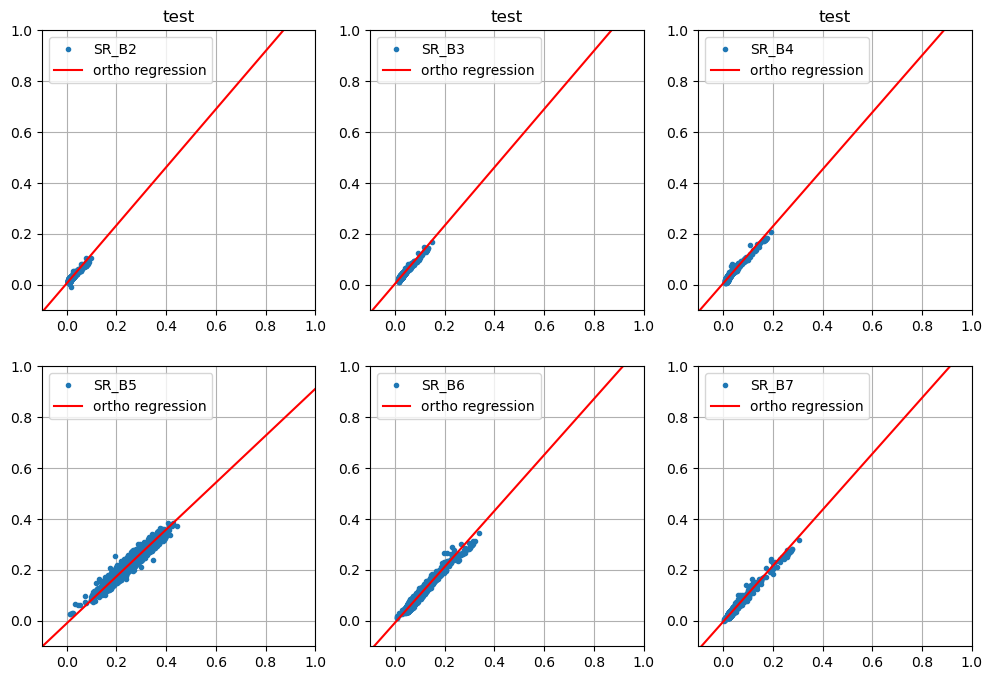

In [13]:
plot_orthoregress( coeffs, im_stack )

In [ ]:
# check selected images and results 
M1 = geemap.Map()
M1.centerObject(aoi, 11)
#M1.addLayer(reference_new.select(visnirbands), visnirparams, 'L9')
#M1.addLayer(target.select(visnirbands), visnirparams, 'L5')
#M1.addLayer(im_norm.select(visnirbands), visnirparams, 'L5_norm')
M1.addLayer(nc,{'min': 0, 'max': 1, 'palette': ['red']}, 'no change', True)
M1

Map(center=[49.95825012032068, 14.974934682135093], controls=(WidgetControl(options=['position', 'transparent_…

In [15]:
# set projection to the same as the reference image
im_norm = im_norm.reproject(crs=reference.projection(), scale=reference.projection().nominalScale())
im_norm_cliped = im_norm.clip(aoi)
crs_info_norm = im_norm_cliped.projection().getInfo()

print(crs_info_norm['crs'], crs_info_norm['transform'])
print(crs_info_reference_n['crs'], crs_info_reference_n['transform'])
print(crs_info_target['crs'], crs_info_target['transform'])
crs_info_reference_n == crs_info_norm # check if the projections are the same

norm_names = ee.List(['iMAD_B'+str(i+2) for i in range(6)])
im_norm_cliped = im_norm_cliped.select(0,1,2,3,4,5).rename(norm_names)
im_norm_cliped.projection().getInfo()

noChangeMask = noChangeMask.reproject(crs=reference.projection(), scale=reference.projection().nominalScale())
noChangeMask = noChangeMask.clip(aoi)
crs_info_nc = noChangeMask.projection().getInfo()
crs_info_nc == crs_info_norm

EPSG:32633 [30, 0, 401385, 0, -30, 5688915]
EPSG:32633 [30, 0, 401385, 0, 30, 5688915]
EPSG:32633 [30, 0, 401385, 0, 30, 5688915]


True

In [16]:
# import srtm 
srtm = ee.Image('USGS/SRTMGL1_003').clip(aoi) # SRTM DEM

# reproject to the same projection as the reference image
srtm_repr = srtm.reproject(crs=reference.projection(), scale=reference.projection().nominalScale())
srtm_repr = srtm_repr.clip(aoi)
crs_info_srtm = srtm_repr.projection().getInfo()
print(f'Check SRTM reference system: {crs_info_srtm == crs_info_nc}')

# Create slope and aspect from SRTM data
slope = ee.Terrain.slope(srtm_repr).clip(aoi) # slope
aspect = ee.Terrain.aspect(srtm_repr).clip(aoi) # aspect
crs_info_slope = slope.projection().getInfo()
print(f'Check SRTM derivates reference system: {crs_info_slope == crs_info_srtm}') # check if the projections are the same, if TRUE, crs of aspect is the same as well

all_bands = ee.Image.cat(reference_new.clip(aoi), target.clip(aoi), im_norm_cliped.clip(aoi), noChangeMask.clip(aoi))
all_bands_srtm = all_bands.addBands(srtm_repr).addBands(slope).addBands(aspect)
all_bands_reproj = all_bands_srtm.reproject(crs=reference.projection(), scale=reference.projection().nominalScale())
all_bands_fl = all_bands_reproj.toFloat().setDefaultProjection(crs=reference.projection())
all_bands_fl.clip(aoi)
all_bands_fl

Check SRTM reference system: True
Check SRTM derivates reference system: True


In [17]:
vis_params_l9 = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],  # R-G-B
    'min':   0,
    'max':   0.2,
    'gamma': 0.9
}
vis_params_l5 = {
    'bands': ['SR_B4_1', 'SR_B3_1', 'SR_B2_1'],  # R-G-B
    'min':   0,
    'max':   0.2,
    'gamma': 0.9
}
vis_params_imad = {
    'bands': ['iMAD_B4', 'iMAD_B3', 'iMAD_B2'],  # R-G-B
    'min':   0,
    'max':   0.2,
    'gamma': 0.9
}

M1.addLayer(all_bands_fl, vis_params_l9, 'Landsat 9 – RGB')
M1.addLayer(all_bands_fl, vis_params_l5, 'Landsat 5 – RGB')
M1.addLayer(all_bands_fl, vis_params_imad, 'irmad – RGB')
M1 # GRAY pixels are no-change pixels

Map(bottom=178204.0, center=[49.95825012032068, 14.974934682135093], controls=(WidgetControl(options=['positio…

In [ ]:
# Export to Google Drive
driveexport = ee.batch.Export.image.toDrive(all_bands_fl,
                        description='IMAD_10_rescaled',
                        folder='EngineExports',
                        region=aoi,
                        crs='EPSG:32633',
                        fileNamePrefix='imad10Itnew_SWIR_rescaled',
                        fileFormat='GeoTIFF',
                        scale=30, maxPixels=1e12)
driveexport.start()
print('Exporting iMAD to Google Drive\n task id: %s'%str(driveexport.id))

Exporting iMAD to Google Drive
 task id: YLEIULRDAUIPMJFVMIM56PNU
